In [22]:
import seaborn as sns
sns.set(rc={'axes.facecolor': 'dimgrey', 'grid.color': 'lightgrey'})
import pandas as pd
import torch
import copy
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader

In [23]:
%run utils.ipynb
%run gcn_model.ipynb
%run GAT_model.ipynb

In [24]:
# class 1 is illicit, 2 is licit, unknown is unknown
labels = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edges = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
nodes = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

In [25]:
indexes = labels.index[labels["class"] != "unknown"].tolist()
labels_new = labels[labels["class"] != "unknown"]
nodes_new =  nodes.take(indexes)
edges_new = edges.loc[edges["txId1"].isin(labels_new["txId"])].loc[edges["txId2"].isin(labels_new["txId"])]
nodes_new.shape, labels_new.shape, edges_new.shape

((46564, 167), (46564, 2), (36624, 2))

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [27]:
data, graph_info = create_graph(nodes_new, edges_new, labels_new, device)
data

Data(x=[46564, 165], edge_index=[2, 36624], y=[46564])

In [28]:
# generate test and train masks
train_p = 0.8
# indices of the illicit and licit transaction nodes
illicit_idx = (data.y == 0).nonzero(as_tuple=True)[0]
# Generate random permutation of indices
illicit_train, illicit_test = torch.utils.data.random_split(illicit_idx, lengths=[train_p, (1-train_p)])

# the same for the licit nodes
licit_idx   = (data.y == 1).nonzero(as_tuple=True)[0]
licit_train, licit_test = torch.utils.data.random_split(licit_idx, lengths=[train_p, (1-train_p)])
# obtain the training and test "masks", i.e. indices for the train and test sets
train_mask = torch.cat((torch.tensor(illicit_train), torch.tensor(licit_train)))
test_mask  = torch.cat((torch.tensor(illicit_test), torch.tensor(licit_test)))

In [29]:
loader = DataLoader([data], batch_size = 1)

In [30]:
GCN = GNN_Example(node_dim=data.x.shape[1], edge_dim=1, output_dim=2, hidden_dim=256, n_gnn_layers=3, K=2, dropout_rate=0.1).to(device)

In [31]:
lr = 1e-3
epochs = 50
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(GCN.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_test_loss = 0
best_result = None
train_losses = []
test_losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(GCN, loader,train_mask, optimizer, loss_fn, device)
    train_losses.append(loss)
    result, test_loss = test(GCN, loader,loss_fn,test_mask, device)
    test_losses.append(test_loss)
    if test_loss > best_test_loss:
        best_test_loss = test_loss
        best_model = copy.deepcopy(GCN)
    if epoch % 10 == 0:
        print("Epoch: ", epoch)
        for item, amount in result.items():
                print("{} ({})".format(item, amount))
        print("############################")
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "gcn.pt")

Epoch:  10
0 ({'precision': 0.6836734693877551, 'recall': 0.07378854625550661, 'f1-score': 0.13320079522862824, 'support': 908})
1 ({'precision': 0.9087159448605232, 'recall': 0.9963108413661788, 'f1-score': 0.9504995458673934, 'support': 8403})
accuracy (0.9063473311137364)
macro avg ({'precision': 0.7961947071241391, 'recall': 0.5350496938108427, 'f1-score': 0.5418501705480108, 'support': 9311})
weighted avg ({'precision': 0.8867700134107034, 'recall': 0.9063473311137364, 'f1-score': 0.8707973371271936, 'support': 9311})
############################
Epoch:  20
0 ({'precision': 0.9352941176470588, 'recall': 0.525330396475771, 'f1-score': 0.6727785613540197, 'support': 908})
1 ({'precision': 0.9510282922395182, 'recall': 0.9960728311317386, 'f1-score': 0.9730295280167404, 'support': 8403})
accuracy (0.9501664697669423)
macro avg ({'precision': 0.9431612049432885, 'recall': 0.7607016138037548, 'f1-score': 0.82290404468538, 'support': 9311})
weighted avg ({'precision': 0.9494939102687361

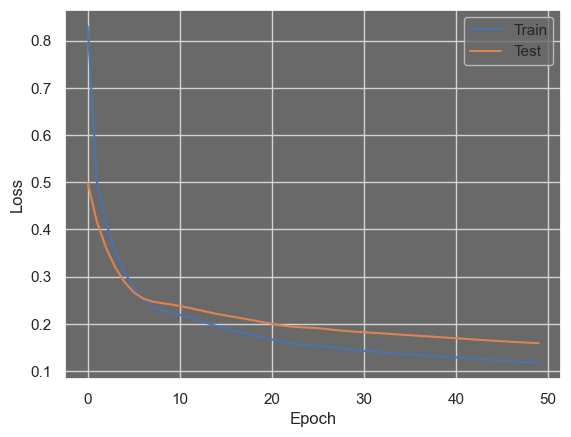

In [32]:
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [67]:
from torch_geometric.explain import ModelConfig, ExplainerConfig, GNNExplainer

node_index =[8440, 8716, 8728, 8734, 8757, 8760, 8762, 8763, 8765, 8773, 8776, 8808]

#[8041, 8107, 8157, 8170, 8368, 8394, 8415, 8439, 8440, 8455, 8493, 8496, 8530, 8567, 8568, 8579, 8590, 8594, 8612, 8624, 8657, 8674, 8687, 8696, 8716, 8728, 8734, 8757, 8760, 8762, 8763, 8765, 8773, 8776, 8808, 8814, 8819, 8827, 8845, 8846, 8856, 8874, 8882, 8900, 8902, 8912, 8915, 8921, 8946, 8986, 8987] #illicit_idx[:200].tolist()

from torch_geometric.explain import Explainer
explainer = Explainer(
    model=GCN,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),threshold_config=None
)
explanation = explainer(data.x, data.edge_index, index=node_index)

In [68]:
from torch_geometric.explain.metric import fidelity
fid_pm = fidelity(explainer, explanation)
print(fid_pm)
explanation.visualize_graph('subgraph.png', backend="networkx")

(1.0, 0.0)


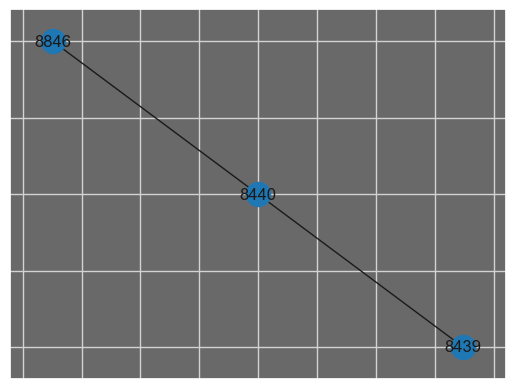

In [72]:
import networkx as nx
edge_list = data.edge_index.cpu().detach().numpy()
G = nx.from_edgelist(edge_list.T)
n = list(G.neighbors(8440))
n.append(8440)
g = G.subgraph(n)
nx.draw_networkx(g)

In [23]:
GAT = GraphAttentionNetwork(node_dim=data["train"][0].x.shape[1], output_dim=2, hidden_dim=256, n_gnn_layers=1, heads=2, dropout_rate=0.5).to(device)

KeyError: 'train'

In [42]:
lr = 1e-3
epochs = 50
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(GAT.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(GAT, data['train'], optimizer, loss_fn, device)
    losses.append(loss)
    result = test(GAT, data, device)
    train_acc, val_acc, test_acc, train_auc, val_auc, test_auc = result
    if val_auc > best_valid_auc:
        best_valid_auc = val_auc
        best_model = copy.deepcopy(GAT)
        best_result = [train_acc, val_acc, test_acc, train_auc, val_auc, test_auc]
    if epoch % 10 == 0:
        print('Epoch: {:02},'.format(epoch),
              'Loss:{:.4f}'.format(loss),
              'Train:\n{}\n'.format(train_acc),
              'Train_auc_roc: {}'.format(train_auc),
              '\n\n'
              'Valid:\n{}\n'.format(val_acc),
              'Val_auc_roc: {}'.format(val_auc),
              '\n\n'
              'Test:\n{}\n'.format(test_acc),
              'Test_auc_roc: {}'.format(test_auc),
              '\n'
              )
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "gat.pt")

NameError: name 'GAT' is not defined

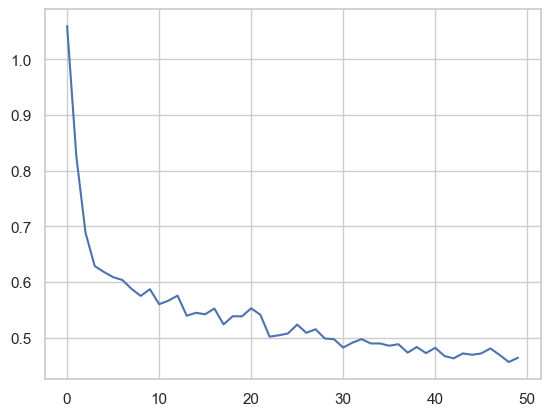

In [63]:
plt.plot(losses)
plt.show()

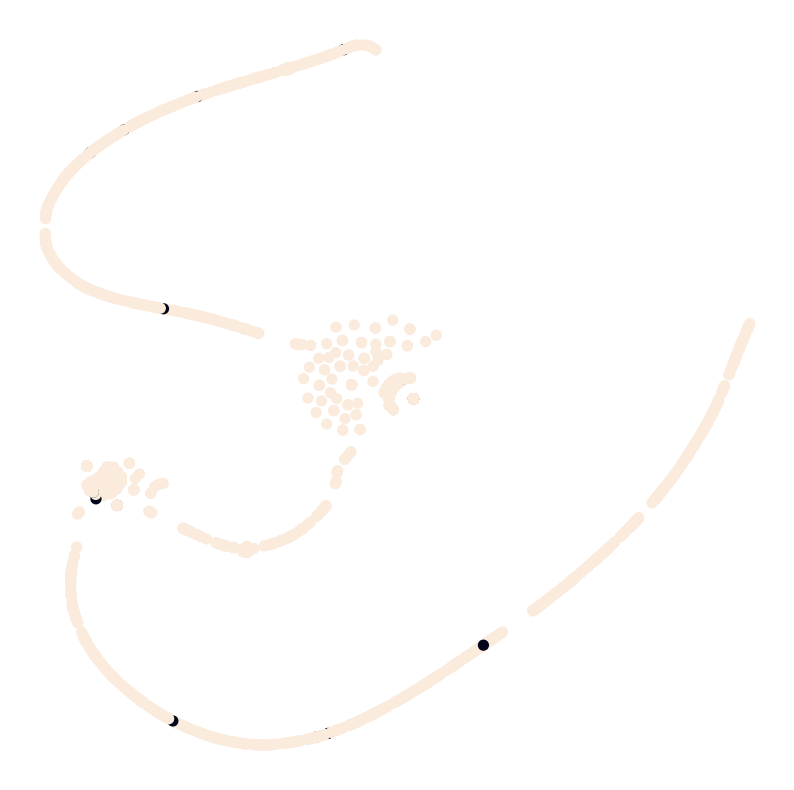

In [64]:
from sklearn.manifold import TSNE

untrained_gat = GraphAttentionNetwork(node_dim=data["train"][0].x.shape[1], output_dim=2, hidden_dim=256, n_gnn_layers=1, heads=2, dropout_rate=0.5).to(device)

# Get embeddings
h = untrained_gat(data["train"][0])

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
            init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data["train"][0].y)
plt.show()

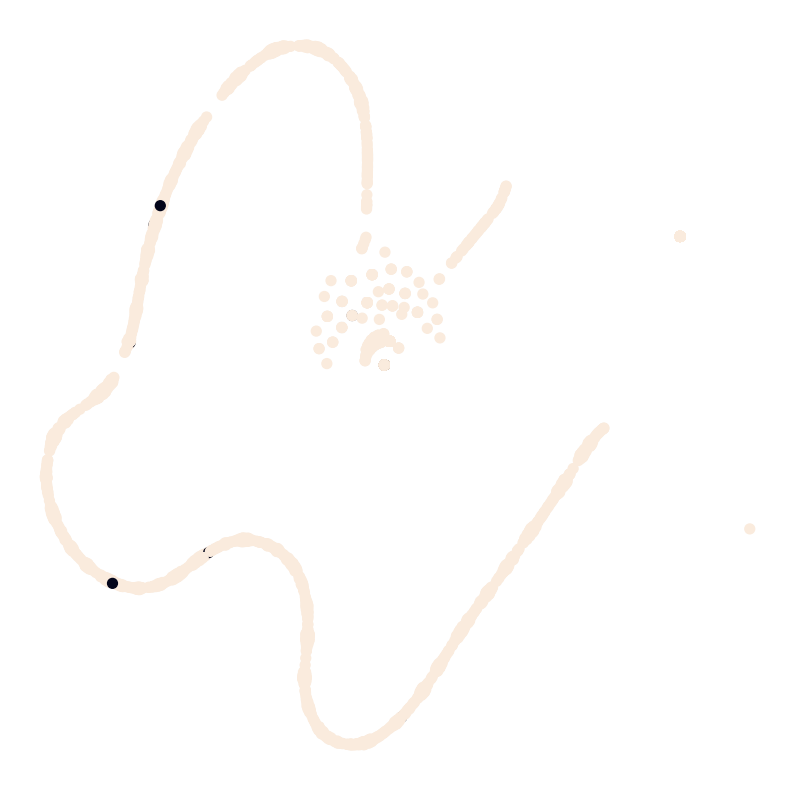

In [66]:
# Get embeddings
checkpoint = torch.load("gat.pt", map_location=device)
GAT = GraphAttentionNetwork(node_dim=data["train"][0].x.shape[1], output_dim=2, hidden_dim=256, n_gnn_layers=1, heads=2, dropout_rate=0.5).to(device)
GAT.load_state_dict(checkpoint["net"])

h = GAT(data["train"][0])

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
            init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data["train"][0].y)
plt.show()